# Projeto sobre algortimos de aprendizado não-supervisionados

Projeto desenvolvido por: Maurício de Souza, RA 184477 (parte 1 e 2) e Natan Rodrigues de Oliveira, RA 175154 (parte 1 e 2 ).

#Parte 1

Nesta primeira parte, vamos implementar dois algoritmos de aprendizado não-supervisionado: K-Means e DBScan.

Usaremos um conjunto de dados com mais de 500 pontos em duas dimensões. Os dados estão armazenados no drive dos autores e com o link compartilhável utilizado neste notebook. Para rodá-lo, basta se autenticar com o gmail ou dac institucional.

##Autenticação

In [ ]:
!pip install PyDrive &> /dev/null
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Loading Data para o diretório atual
clusterDat = drive.CreateFile({'id':'1XJR-x32HN3DaiFQcdLYj1KvSxfCKg-yO'})
clusterDat.GetContentFile('cluster.dat')

In [ ]:
from numpy import sqrt, square, array, zeros_like, where, full
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing



##Get Data

Ao trazer nossos dados para a memória, observamos que suas features estão com métricas bem diferentes entre si, o que pode causar problemas aos nossos algoritmos, pois uma feature terá um peso maior nos cálculos das distâncias eucliadianas, usadas nestas implementações.

Para adequar nossos dados, usaremos a normalização dos dados a fim de igualar os pesos de cada feature.

In [ ]:
points = open('cluster.dat', 'r')
X = []
for point in points:
    x,y = point.split(' ')
    X.append(np.array([float(x), float(y)]))
X = np.array(X)
X

array([[1555.  ,   28.65],
       [1490.  ,   27.55],
       [1445.  ,   28.35],
       ...,
       [3525.  ,   26.  ],
       [3570.  ,   26.15],
       [3440.  ,   25.6 ]])

##Split Data (90/10)

In [ ]:
X_train, X_test = train_test_split(X, train_size = 0.90, shuffle=True)
print(f'Conjunto de treino com {X_train.shape[0]} dados')
print(f'Conjunto de teste com {X_test.shape[0]} dados')

Conjunto de treino com 515 dados
Conjunto de teste com 58 dados


##Feature Scaling

In [ ]:
scaler = preprocessing.MinMaxScaler()
X_train_sca = scaler.fit_transform(X_train)
X_train_sca

array([[0.57121212, 0.13970588],
       [0.05909091, 0.88786765],
       [0.49848485, 0.20404412],
       ...,
       [0.46666667, 0.11764706],
       [0.36515152, 0.29963235],
       [0.9969697 , 0.73529412]])

##K-Means

O algoritmo K-Means objetiva agrupar (clusterizar) dados em k grupos, de acordo com suas similaridades. Neste exemplo, chamamos de similar dados que estão mais próximos entre si no espaço eucliadiano 2D.

Tal algoritmo têm dois passos principais: a inicialização dos k clusters e suas iterações para reajuste de seus centroides.

Para a inicialização estamos utilizando o algoritmo k-means++ que, no primeiro momento, escolhe um ponto aleatório do conjunto para ser um centroide do primeiro cluster e, após a primera inicialização, o algoritmo seleciona k-1 outros centroides com probabilidade proporcional à distância aos centroides já escolhidos.

As iterações posteriores têm por fim recalcular as posições dos centroides de acordo com a proximidade dos dados. Este passo converge quando os centroides não se alteram mais.

In [ ]:
class KMeans():

  def __init__(self,n_clusters=2 , it_max=300,err=0.004, n_init=10):
    self.n_clusters=n_clusters
    self.centroids = None
    self.centroidss = []
    self.it_max = it_max
    self.inertia_ = None
    self.inertias =[]
    self.err=err  #Erro de parada
    self.n_init=n_init #Treinamos n_init modelos e retornamos o que possui a menor inertia
    

  def fit(self, X):

    for n_ in range(self.n_init): #Rodamos n_init modelos e pegamos o de menor inertia
      #Incialização centroids
      self.initialize_k_centroids(X)
      
      #Treinaremos por self.it_max iterações
      inertias = [0,0,0]
      for it in range(self.it_max):
        #Determina o cluster em que cada ponto está
        cluster_point = self.predict(X)
        #Calculamos a nova média para cada centróide
        new_centroids = zeros_like(self.centroids)
        dic = {}
        for i, p in enumerate(X):
          dic[cluster_point[i]] = dic.get(cluster_point[i], 0) + 1
          col = cluster_point[i]
          new_centroids[col] = new_centroids[col] + (p- new_centroids[col])/dic[col]  #media = (media*(n-1) + new_elem)/n = media + (new_elem - media )/n
        #Atualiza com os novos centroids calculados
        self.centroids = new_centroids

        #Comparamos 3 inertias consecutivas. Sendo a última - penúltima< err e  penúltima - anti-penúltima < err
        self.inertia_=self.inertia(X)
        k=it%3
        inertias[k] = self.inertia_
        if(it>1 and inertias[k]-inertias[k-1]<self.err and inertias[k-1]-inertias[k-2]<self.err):   break
      
      
      self.centroidss.append(self.centroids)
      self.inertias.append(self.inertia_)

    self.centroids = self.centroidss[array(self.inertias).argmin()]#Pegamos o centroid com menor inertia

    return self

  def transform(self,X):
    return self.predict(X)

  def fit_transform(self,X):
    self.fit(X)
    return self.transform(X)

  def predict(self,X):
    #Qual cluster cada ponto está
    return self.__distance_to_all(X).argmin(axis=1)

  def __distance_to_all(self, X):
    #Calculamos a distância de cada ponto a todos os centroids se utilizando do recurso de broadcasting do numpy
    dists=np.zeros((len(X),len(self.centroids)))
    for i, c in enumerate(self.centroids):
      dists[:,i] = sqrt(square(X-c).sum(axis=1)) #Uma coluna j contém a distância ao centroid/cluster j para cada ponto na linha i 
    return dists

  def inertia(self, X ):
    return square(self.__distance_to_all(X).min(axis=1)).sum()

  def initialize_k_centroids(self,X):
    random.seed()
    self.centroids = [X[np.random.randint(X.shape[0])]]
    for i in range(self.n_clusters-1):
        dist = []
        for point in X:
            min_local = sys.maxsize
            for centroid in self.centroids:
                cur_dist = np.sum((point - centroid)**2)
                min_local = min(min_local, cur_dist)
            dist.append(min_local)

        pop = [i for i in range(len(dist))]
        index = random.choices(pop, weights=dist, k=1)
        next_centroid = X[index][0]

        self.centroids.append(next_centroid)
        dist.clear()
    return self.centroids
  
  


      





####Training

Ao treinar os dados, separamos em duas partes: dados normalizados e não-normalizados para observar e avaliar a diferença entre os clusters formados de acordo com a disparidade de escala das features.

In [ ]:
n_models = 10 #Treinaremos 10 modelos de 1 a 10 clusters

#####Treino sobre os dados normalizados

In [ ]:
import time
inicio = time.time()

models_sca={}
for i in range(1, n_models+1):
  models_sca[i] = KMeans(n_clusters=i).fit(X_train_sca)


print(f'Tempo de execução = {(time.time() - inicio)/60}min')


Tempo de execução = 0.12616709470748902min


#####Treino sobre os dados não normalizados

In [ ]:
import time
inicio = time.time()


models={}
for i in range(1, n_models+1):
  models[i] = KMeans(n_clusters=i).fit(X_train)


print(f'Tempo de execução = {(time.time() - inicio)/60}min')


Tempo de execução = 0.12557725509007772min


###Elbow Method

Ao usar o algoritmo K-Means queremos agrupar dados similares entre si, dividindo nossos agrupamentos em k grupos ou clusters. Como encontrar um bom k para um conjunto de dados sem labels?

Os métodos Elbow e Silhouette nos ajudam a determinar uma boa escolha para k baseado i) em suas distâncias quadradas aos centroids ou ii) de acordo com a densidade e separação dos clusters.

O método Elbow é descrito em i) e o Silhouette em ii).

Ao rodarmos o método Elbow nos dados normalizados e não-normalizados, observamos que há escolhas diferentes para o número k de clusters para o nosso conjunto. 

Com os dados normalizados, obtemos k=3 clusters e para os dados não normalizados, k=2 clusters. É possível ver que claramente temos 3 clusters em nosso conjunto, o que reafirma a discussão no começo deste notebook sobre a importância de normalizar os dados para que features não se sobreassaim sobre as outras.

#####Elbow sobre os dados normalizados

85.13167520693915
44.33618801854226
11.316220736442302
9.423188522260336
7.248334608831127
6.166033090930686
5.459749617263732
4.401287806595404
3.9690498728566936
3.329024961752464


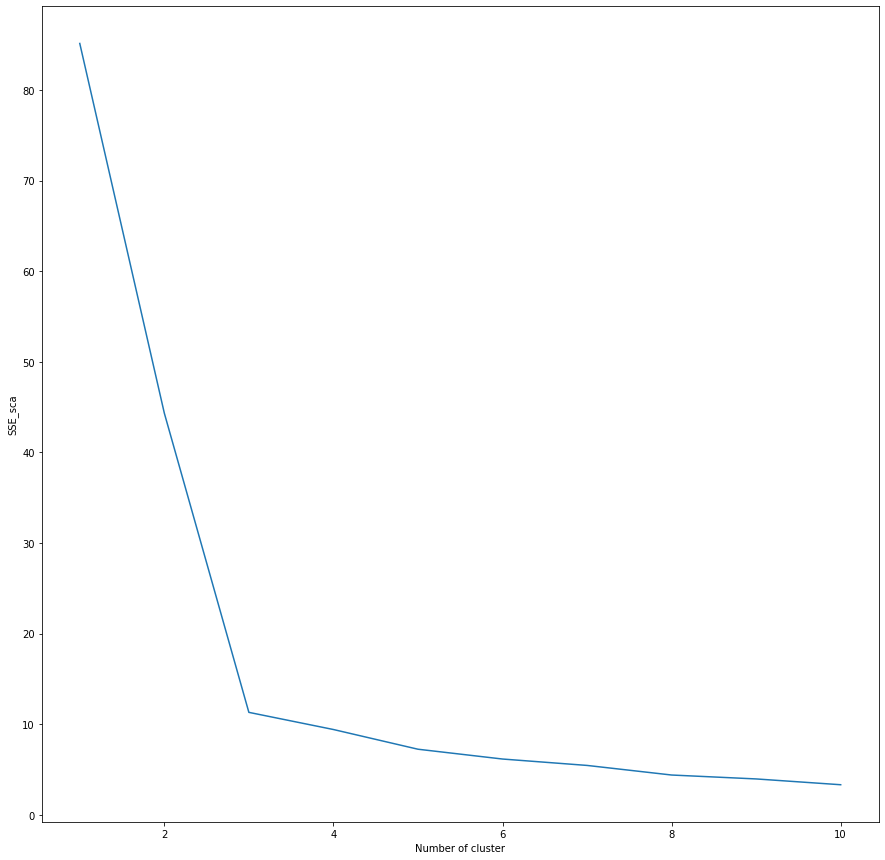

In [ ]:
sse_sca = {}
for i, model_sca in models_sca.items():
    sse_sca[i] = model_sca.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    print(sse_sca[i])
plt.figure(figsize=(15, 15))
plt.plot(list(sse_sca.keys()), list(sse_sca.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE_sca")
plt.show()

#####Elbow sobre os dados não normalizados

413012674.0124078
114130029.62122664
65789363.41980831
19000452.160433993
12514094.421644365
9603208.063831152
8334656.903165717
5437646.660493882
4167945.4879263644
3441575.074377491


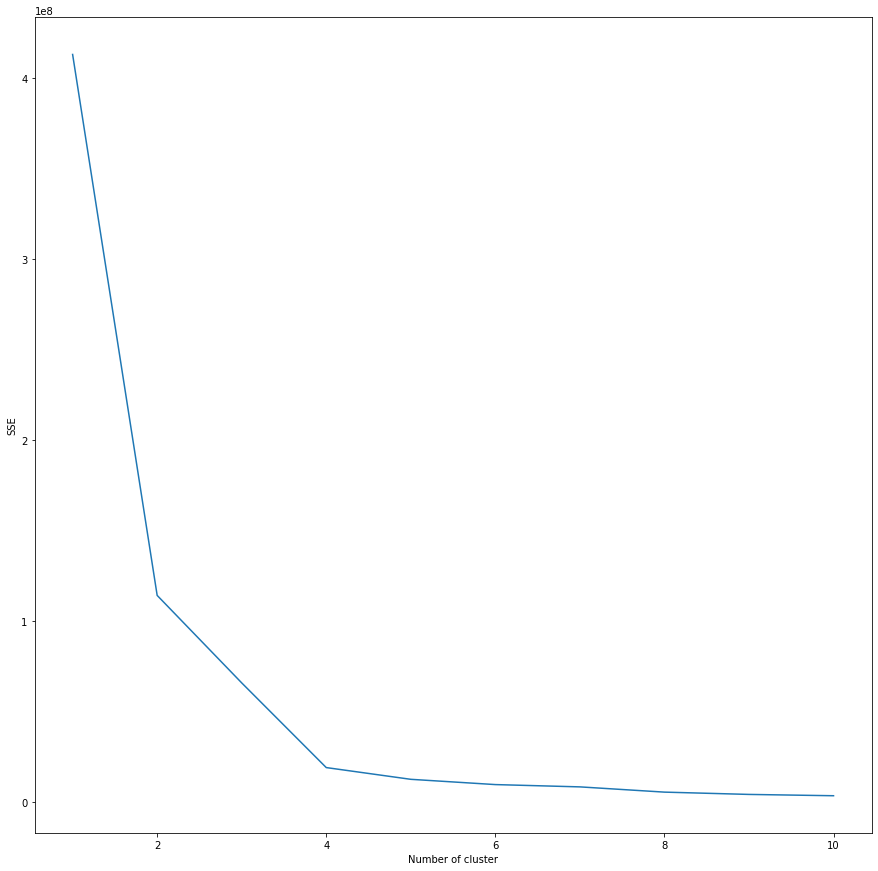

In [ ]:
sse = {}
for i, model in models.items():
    sse[i] = model.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    print(sse[i])
plt.figure(figsize=(15, 15))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#####Optmal K


In [ ]:
def optmal_k(n_models, sse):
  maximo = -1
  n_cluster = 1
  for i in range(1,n_models-2):
    a=abs(sse[i]-sse[i+1]-(sse[i+1]-sse[i+2]))
    if(a>maximo):
      maximo = a
      n_cluster = i+1
  return n_cluster

In [ ]:
#Optmal K para os modelos não normalizados
K_opt = optmal_k(n_models, sse)
K_opt

2

In [ ]:
#Optmal K para os modelos  normalizados
K_sca_opt = optmal_k(n_models, sse_sca)
K_sca_opt

3

###Model Evaluation 

Com objetivo de avaliar o nosso modelo, importamos o método Silhouette do scikit learn do Python. O mesmo resultado se mantém, para dados normalizados (padronizados) obtemos três clusters, enquanto para os dados não-normalizados, apenas 2.

####Modelo com padronização

Text(0.5, 1.0, 'Predict data')

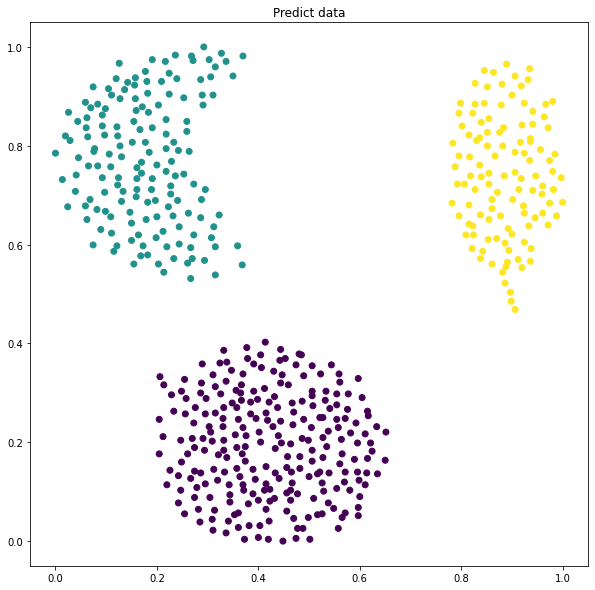

In [ ]:
model_sca=models_sca[K_sca_opt]
predict_sca=model_sca.predict(X_train_sca)
plt.figure(figsize=(10, 10))
plt.scatter(X_train_sca[:, 0], X_train_sca[:, 1], c=predict_sca)
plt.title("Predict data")


####Modelo sem padronização

Text(0.5, 1.0, 'Predict data')

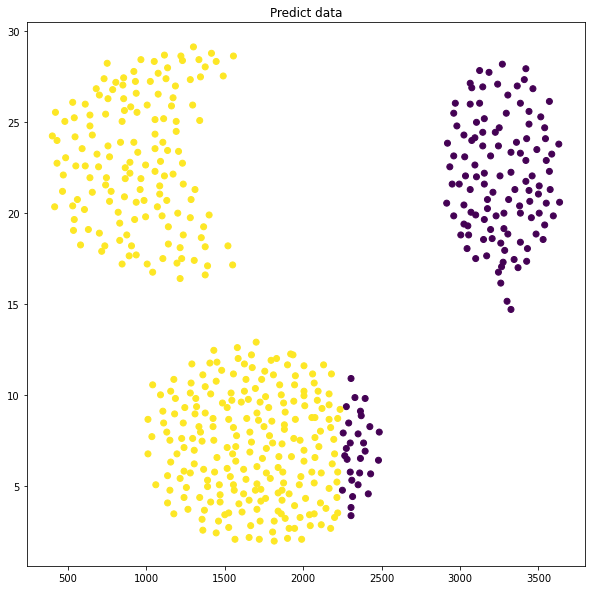

In [ ]:
model=models[K_opt]
predict=model.predict(X_train)
plt.figure(figsize=(10, 10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.title("Predict data")


####Silhouette

#####Com Padronização


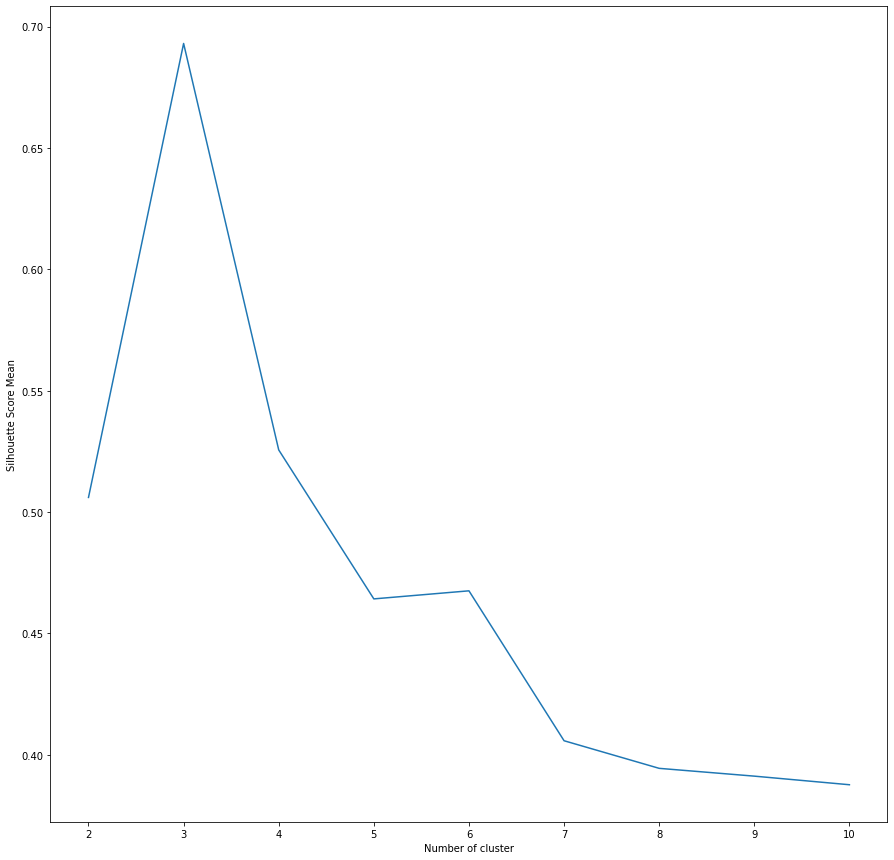

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
#####Com Padronização

silhouette_sca = {}
for i, model in models_sca.items():
    if(i==1): continue
    silhouette_sca[i] = silhouette_score(X_train_sca, model.predict(X_train_sca))

plt.figure(figsize=(15, 15))
plt.plot(list(silhouette_sca.keys()), list(silhouette_sca.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score Mean")
plt.show()


For n_clusters =3  The average silhouette_score is :0.6930366396766426


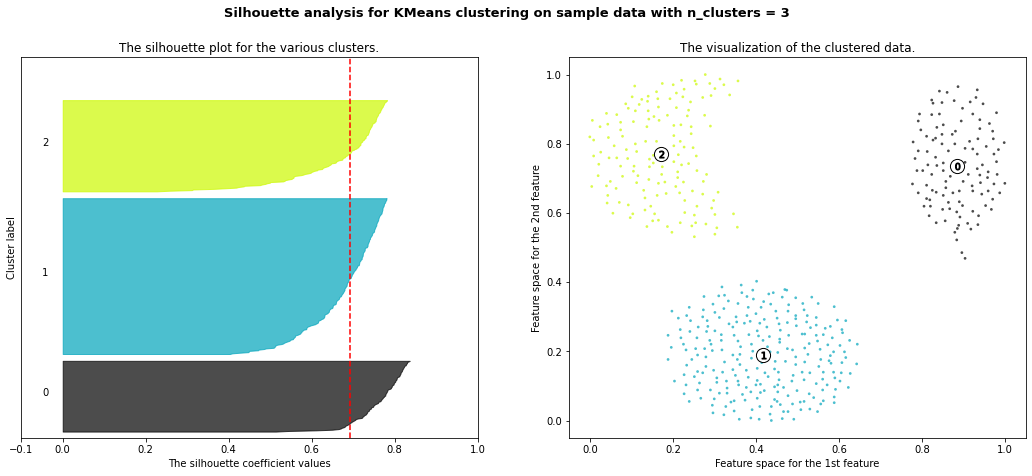

In [ ]:

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

n_clusters = K_sca_opt

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

model = models_sca[K_sca_opt] 
clusterer = model
X = X_train_sca 
cluster_labels = clusterer.predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(f'For n_clusters ={n_clusters}  The average silhouette_score is :{silhouette_avg}')
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear 
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.centroids
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(f'Silhouette analysis for KMeans clustering on sample data with n_clusters = {K_sca_opt}', fontsize=13, fontweight='bold')

plt.show()

#####Sem Padronização

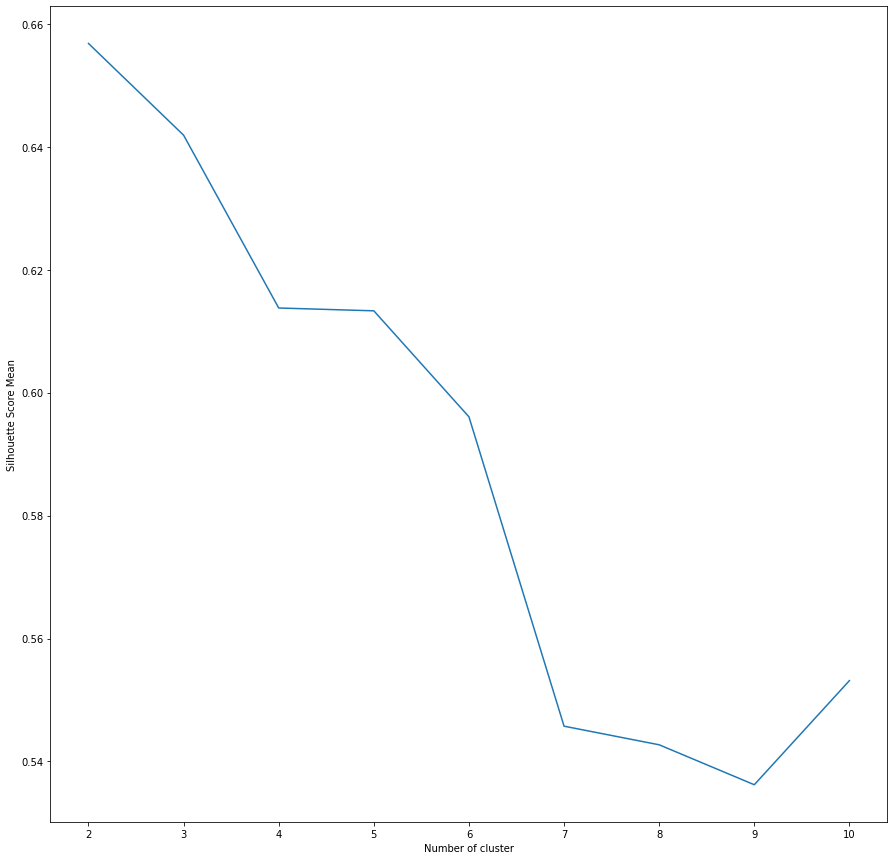

In [ ]:

from sklearn.metrics import silhouette_score, silhouette_samples

silhouette = {}
for i, model in models.items():
    if(i==1): continue
    silhouette[i] = silhouette_score(X_train, model.predict(X_train))

plt.figure(figsize=(15, 15))
plt.plot(list(silhouette.keys()), list(silhouette.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score Mean")
plt.show()



For n_clusters =2  The average silhouette_score is :0.6568190446967479


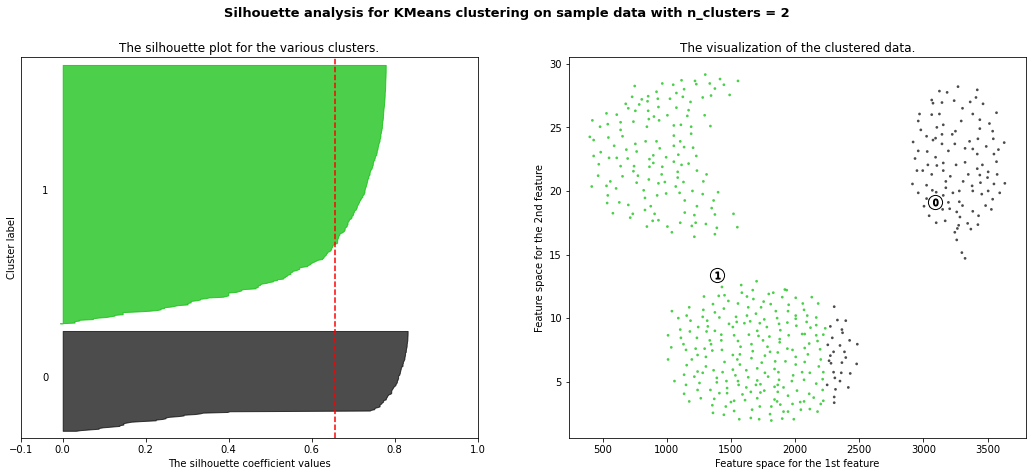

In [ ]:

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

n_clusters = K_opt

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

model = models[K_opt] 
clusterer = model
X = X_train 
cluster_labels = clusterer.predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(f'For n_clusters ={n_clusters}  The average silhouette_score is :{silhouette_avg}')
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear 
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.centroids
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(f'Silhouette analysis for KMeans clustering on sample data with n_clusters = {K_opt}', fontsize=13, fontweight='bold')

plt.show()

###Conclusão  K-Means
Notamos que o coeficiente médio do silhouette sobre os dados normalizados possuio seu pico máximo em K=3, coincidindo com o optmal k do elbow method. Vemos, também, por uma análise visual, que os dados se encaixam melhor em 3 clusters, fato que tal método concordou. Já o modelo não normalizado possuio optmal k igual 2 e seu coeficiente médio do silhouette não apresentou pico, dificultando a análise do modelo e deixando-o confuso. Portanto, tais fatos reforçam a importância já citada da normalização dos dados, que especificamente nesse cenário, um fator que tem bastante influência para ocorrências não esperadas é a primeira coluna possuir maior dimensão que a segunda coluna.

##DBSCAN

O segundo algoritmo que implementamos nesta parte é o DBScan. Este é também um algoritmo de clusterização, mas analisa a densidade de dados ao formar os clusters, desconsiderando totalmente pontos muito distantes, ou seja, é um algortimo robusto a outliers. Também consegue determinar clusters com diversos formatos, devido à sua forma de escolher os pontos ditos centrais dos clusters, em contraposição com o k-means que sempre considera todos os pontos do conjunto e é limitado a clusters esféricos N-dimensionais.

Abaixo, treinamos o DBScan e analisamos seu comportamento ao clusterizar os nossos dados e também as suas escolhas de pontos centrais e periféricos.

In [ ]:

def DBSCAN(X, eps, minPts):
  neighborhood = lambda p : sqrt(square(X-p).sum(axis=1))<=eps
  labels = full(len(X), -1 ) #-1 -> undefined, -2 -> noise
  color = -1
  for i, p in enumerate(X):
    if(labels[i]!=-1): continue
    
    N = neighborhood(p)
    if(len(N[N])<minPts):
      labels[i] = -2 #Noise
      continue
    color+=1
    labels[i] = color
    S = set(where(N)[0])
    for j in S:
      if(labels[j]==-2): labels[j] = color
      if(labels[j]!=-1): continue
      N = neighborhood(X[j])
      labels[j] = color
      if(len(N[N])>=minPts):
        S = S.union(set(where(N)[0]))  
  return labels
      


###Training

#####Treino sobre os dados normalizados

In [ ]:
params_sca = [
  {
    "minPts" : 3,
    "eps" : 0.35
  },
  {
    "minPts" : 3,
    "eps" : 0.6,
  },
  {
    "minPts" : 10,
    "eps" : 0.3
  },
  {
    "minPts" : 10,
    "eps" : 1.3
  }
]
params_sca

[{'eps': 0.35, 'minPts': 3},
 {'eps': 0.6, 'minPts': 3},
 {'eps': 0.3, 'minPts': 10},
 {'eps': 1.3, 'minPts': 10}]

In [ ]:

import time
inicio = time.time()

predicts_sca = []
for param in params_sca:
  predicts_sca.append(DBSCAN(X_train_sca, param["eps"], param["minPts"]))

print(f'Tempo de execução = {(time.time() - inicio)/60}min')


Tempo de execução = 0.0033442020416259766min


####Treino sobre os dados não normalizados

In [ ]:
params = [
  {
    "minPts" : 3,
    "eps" : 3
  },
  {
    "minPts" : 3,
    "eps" : 10,
  },
  {
    "minPts" : 3,
    "eps" : 20
  },
  {
    "minPts" : 5,
    "eps" : 20
  }
]
params

[{'eps': 3, 'minPts': 3},
 {'eps': 10, 'minPts': 3},
 {'eps': 20, 'minPts': 3},
 {'eps': 20, 'minPts': 5}]

In [ ]:

import time
inicio = time.time()

predicts = []
for param in params:
  predicts.append(DBSCAN(X_train, param["eps"], param["minPts"]))

print(f'Tempo de execução = {(time.time() - inicio)/60}min')


Tempo de execução = 0.00127029021581014min


###Vizualization

####Modelo com padronização
Percebemos abaixo que o modelo padronizado é sensível principalmente ao tamanho do raio(eps) e ao número mínimo de pontos(minPts). Com raio maior, teremos clusteres maiores. Quanto maior o minPts de pontos, a tendência é termos mais noises pontos e mais dependeremos da onde a inicialização começa, pois nosso algoritmos clusteriza os pontos noises com a cor do primeiro ponto core que encontra-o. Vale lembrar que, tal algoritmos tem grande sensibilidades as inicializações pelo fato dos noises serem categorizados da forma supracitada

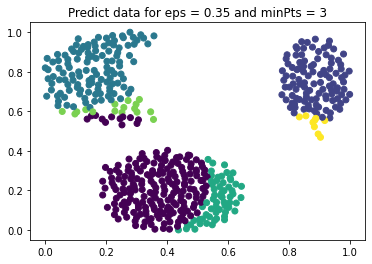

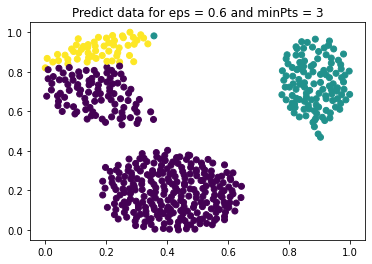

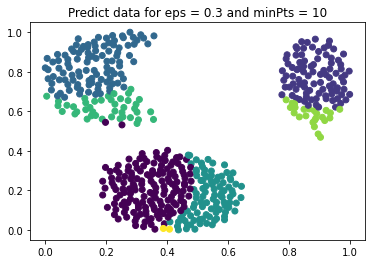

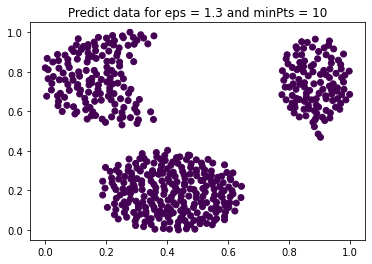

In [ ]:

for i, predict in enumerate(predicts_sca):
  plt.scatter(X_train_sca[:, 0], X_train_sca[:, 1], c=predict)
  plt.title(f'Predict data for eps = {params_sca[i]["eps"]} and minPts = {params_sca[i]["minPts"]}')
  plt.show()


####Modelo sem padronização

Percebemos abaixo que o modelo não padronizado não teve resultados confusos. O fato de algumas features sobresair sobre outras faz com que um ponto que teoricamente pertencesse a cluster, faz com que ele pertença a outro. Mais uma vez mostrando a importância da padronização.

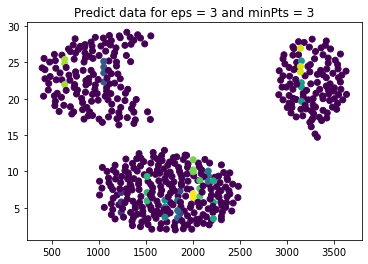

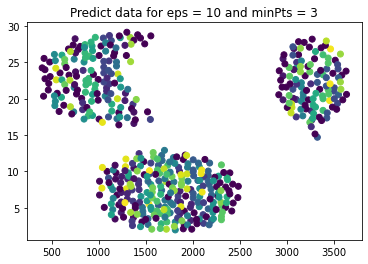

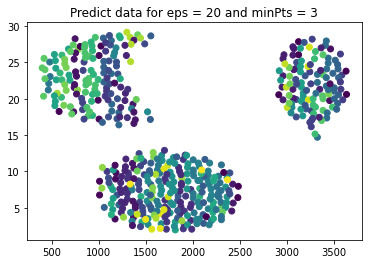

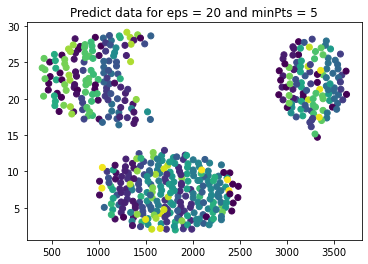

In [ ]:

for i, predict in enumerate(predicts):
  plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
  plt.title(f'Predict data for eps = {params[i]["eps"]} and minPts = {params[i]["minPts"]}')
  plt.show()


###Conclusão  DBSCAN
Como esperado de algoritmos baseados em densidade, como DBSCAN, vimos que tal modelo padronizado é sensível principalmente ao tamanho do raio(eps) e ao número mínimo de pontos(minPts). Além disso, sem normalização, assim como K-means, algumas features se sobressaem a outras deixando-o confuso, pois tais médotos foram baseados no cálculo da distância euclidiada 

##Best Model 

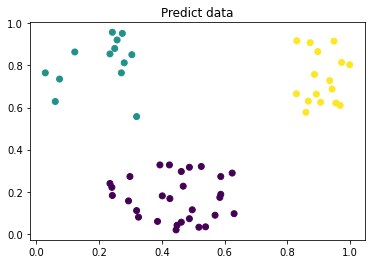

In [ ]:
#Escolhemos o normalizado com 3 clusters
X_test_sca = scaler.transform(X_test)
predict = models_sca[K_sca_opt].transform(X_test_sca)

plt.scatter(X_test_sca[:, 0], X_test_sca[:, 1], c=predict)
plt.title(f'Predict data')
plt.show()



Por fim, vimos que os pontos de tests possuem a forma similar ao encontrado em nosso best model(K-means padronizado com 3 cluesteres)

# Parte 2
#Bank Marketing Data Set

Nesta parte do notebook focamos em redução de dimensionalidade usando PCA, um algoritmo que reduz a dimensão dos dados, simplificando features não impactantes na análise do conjunto.

Usamos o conjunto de dados de ligações do setor de marketing de uma instituição bancária de Portugal contendo informações sobre o cliente como idade, profissão, educação entre outros. O objetivo é predizer se o cliente irá adquirir o termo de depósito.

Para saber mais sobre tal conjunto de dados, verifique o link https://archive.ics.uci.edu/ml/datasets/bank+marketing. O conjunto de dados utilizado foi https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip. 

Para tais predições, vamos fazer a redução de dimensionalidade e aplicar o K-Means, assim como fizemos na parte 1 para averiguar o output e poder relacionar com os dados de treino. Para isso, vamos avaliar o melhor K usando o método Elbow.

In [ ]:
#Loading Data para o diretório atual
bankData = drive.CreateFile({'id':'1mMdCAS01ue5xtwOUhqJ7F0nGveVHQ1og'})
bankData.GetContentFile('bank.zip')

In [ ]:
import pandas as pd     # Para tratamento de dados
from time import time   # Operações com tempo
import zipfile          # Trabalhar com arquivos zips
import csv              # Trabalhar com arquivos csv
import numpy as np
import matplotlib.pyplot as plt #Plotar dados
import collections      
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing





##Get Data

In [ ]:
def loadData(arquivo_zip, arquivo_name):
  with zipfile.ZipFile(arquivo_zip, 'r') as zip: 
      # printing all the contents of the zip file 
      zip.printdir()    
      # extracting all the files 
      print('Extracting all the files now...') 
      zip.extractall() 
      print('Done!')
  with open(arquivo_name) as f:
      df = pd.read_csv(arquivo_name, delimiter =';')      
  return df

In [ ]:
arquivo_zip = 'bank.zip'
arquivo_name = 'bank-full.csv'
df=loadData(arquivo_zip, arquivo_name)
df.tail()

File Name                                             Modified             Size
bank-full.csv                                  2012-02-14 14:40:56      4610348
bank-names.txt                                 2012-02-14 15:10:48         3864
bank.csv                                       2012-02-14 14:38:02       461474
Extracting all the files now...
Done!


age           job   marital  education  ... pdays  previous poutcome    y
45206   51    technician   married   tertiary  ...    -1         0  unknown  yes
45207   71       retired  divorced    primary  ...    -1         0  unknown  yes
45208   72       retired   married  secondary  ...   184         3  success  yes
45209   57   blue-collar   married  secondary  ...    -1         0  unknown   no
45210   37  entrepreneur   married  secondary  ...   188        11    other   no

[5 rows x 17 columns]

##Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1], train_size = 0.75, shuffle=True)
print(f'Número de dados para treino {X_train.shape[0]}')
print(f'Número de dados para teste {X_test.shape[0]}')


Número de dados para treino 33908
Número de dados para teste 11303


##Label encoder
Codificamos as fetures do tipo string

In [ ]:
from sklearn import preprocessing
features_string = set(['job','marital','education','default','housing','loan','contact','month','poutcome']) 
dicionario = { feature:preprocessing.LabelEncoder() for feature in features_string}

#X
X_train_enc = X_train.copy()
for feature in features_string:
  X_train_enc[feature] =dicionario[feature].fit_transform( X_train[feature] )

#y
dicionario['y'] = preprocessing.LabelEncoder()
y_train_enc = dicionario['y'].fit_transform(y_train)

X_train_enc.tail()

age  job  marital  education  ...  campaign  pdays  previous  poutcome
2621    32    1        2          1  ...         3     -1         0         3
44287   37    9        1          1  ...         2    784         3         0
34640   43    7        1          1  ...         2     -1         0         3
6116    36    4        1          2  ...         4     -1         0         3
32381   37    1        1          1  ...         2    147         3         0

[5 rows x 16 columns]

##Feature Scaling

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(X_train_enc)
X_train_sca = scaler.transform(X_train_enc)

X_train_sca

array([[0.32467532, 0.36363636, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.16883117, 0.36363636, 1.        , ..., 0.18947368, 0.00363636,
        0.        ],
       [0.62337662, 0.90909091, 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.32467532, 0.63636364, 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.23376623, 0.36363636, 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.24675325, 0.09090909, 0.5       , ..., 0.17309942, 0.01090909,
        0.        ]])

##PCA
Utilizamos números de componentes iguais a 2, 8 e 12 sobre os dados normalizados

In [ ]:
components = [2, 8, 12] #Variâncias utilizadas

In [ ]:
#PCA com normalização

from sklearn.decomposition import PCA

pcas_sca = { n_components : PCA(n_components=n_components).fit(X_train_sca) for n_components in  components }
for i in components:
  print(f'Soma das variâncias de cada feature igual a {pcas_sca[i].explained_variance_ratio_.sum()}')


Soma das variâncias de cada feature igual a 0.4315563025613079
Soma das variâncias de cada feature igual a 0.9159462714567721
Soma das variâncias de cada feature igual a 0.9941459211946093


In [ ]:
#PCA não normalizado
#12 componentes
pca_enc = PCA(n_components=12).fit(X_train_enc) 
print(f'Soma das variâncias de cada feature igual a {pca_enc.explained_variance_ratio_.sum()}')


Soma das variâncias de cada feature igual a 0.9999999327249801


##K-Means
Para cada número de componentes construímos 6 modelos sobre o K-means, variando de 1 a 6 clusters cada.

####Training

In [ ]:
#Parâmetros
#Treinaremos 6 modelos para cada variância
n_models = 6


In [ ]:
#Normalizado
import time
inicio = time.time()
#Para cada PCA implementamos 6 modelos
models_sca = { n_components:{}  for n_components in components}
for n_components in components:
  for i in range(n_models):
    models_sca[n_components][i+1] = KMeans(n_clusters=i+1).fit(pcas_sca[n_components].transform(X_train_sca))

print(f'Tempo de execução = {(time.time() - inicio)/60}min')
models_sca


Tempo de execução = 6.024042177200317min


{2: {1: <__main__.KMeans at 0x7f6c2d0a8710>,
  2: <__main__.KMeans at 0x7f6c3c273f50>,
  3: <__main__.KMeans at 0x7f6c40fbb2d0>,
  4: <__main__.KMeans at 0x7f6c22c62e50>,
  5: <__main__.KMeans at 0x7f6c2cdff710>,
  6: <__main__.KMeans at 0x7f6c2ce3bf90>},
 8: {1: <__main__.KMeans at 0x7f6c40fd8750>,
  2: <__main__.KMeans at 0x7f6c22f46cd0>,
  3: <__main__.KMeans at 0x7f6c2ce1e750>,
  4: <__main__.KMeans at 0x7f6c3c273890>,
  5: <__main__.KMeans at 0x7f6c22c3b710>,
  6: <__main__.KMeans at 0x7f6c2ce1cdd0>},
 12: {1: <__main__.KMeans at 0x7f6c22c62ed0>,
  2: <__main__.KMeans at 0x7f6c2b7b1790>,
  3: <__main__.KMeans at 0x7f6c22dc4850>,
  4: <__main__.KMeans at 0x7f6c2d0a8a10>,
  5: <__main__.KMeans at 0x7f6c22f1bd10>,
  6: <__main__.KMeans at 0x7f6c2c926c90>}}

In [ ]:
#Normalizado
import time
inicio = time.time()
#Não normalizado
models_enc={}
for i in range(n_models):
  models_enc[i+1] = KMeans(n_clusters=i+1).fit(pca_enc.transform(X_train_enc)) 

print(f'Tempo de execução = {(time.time() - inicio)/60}min')
models_enc

Tempo de execução = 2.0192438920338946min


{1: <__main__.KMeans at 0x7f6c22bd2510>,
 2: <__main__.KMeans at 0x7f6c22f01e10>,
 3: <__main__.KMeans at 0x7f6c22cedd90>,
 4: <__main__.KMeans at 0x7f6c2ce30490>,
 5: <__main__.KMeans at 0x7f6c22bc3a50>,
 6: <__main__.KMeans at 0x7f6c2cdff4d0>}

###Elbow Method

Dados normalizados

<Figure size 432x288 with 0 Axes>

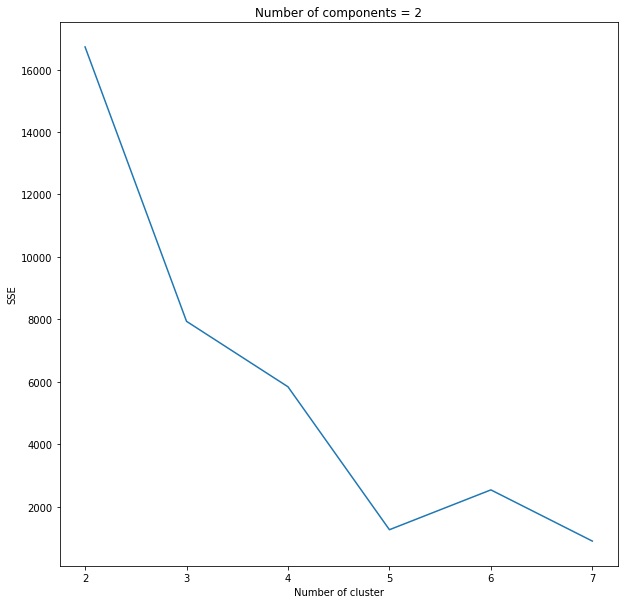

<Figure size 432x288 with 0 Axes>

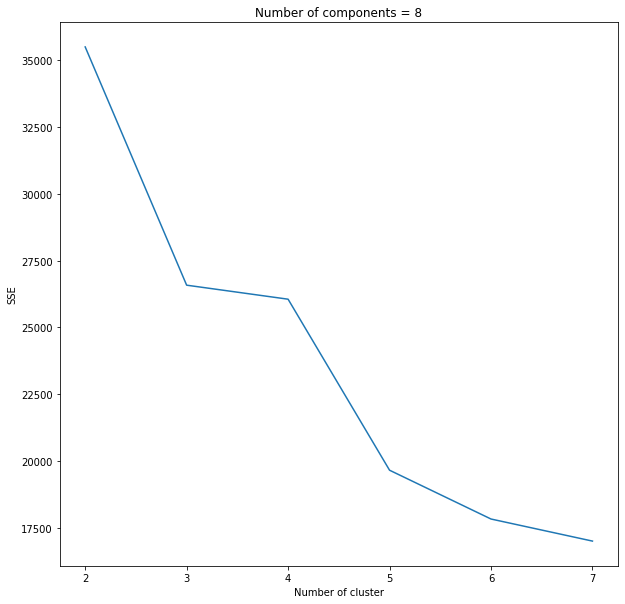

<Figure size 432x288 with 0 Axes>

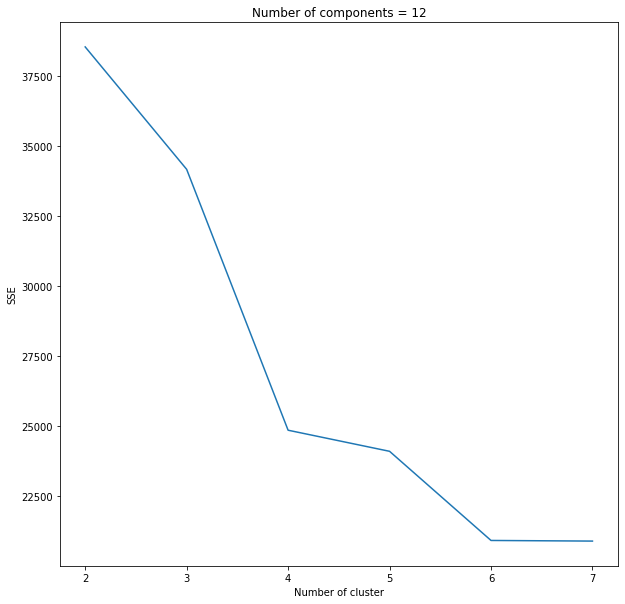

In [ ]:
#Normalizado
sses = {}
for l, models in models_sca.items():
  sse = {}
  for k in models.keys():
      kmeans = models[k]
      sse[k+1] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
  sses[l] = sse
  plt.figure()
  plt.figure(figsize=(10, 10))
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of cluster")
  plt.ylabel("SSE")
  plt.title(f"Number of components = {l}")
  plt.show()

Dados não normalizados

<Figure size 432x288 with 0 Axes>

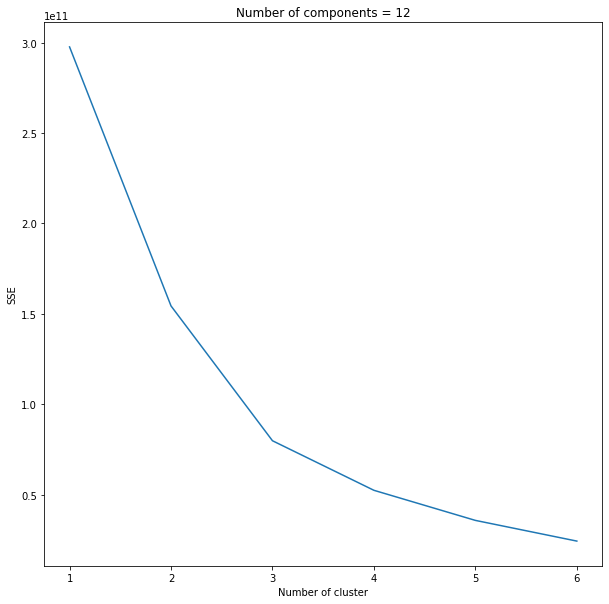

In [ ]:
sse = {}
for k in range(n_models):
    kmeans = models_enc[k+1]
    sse[k+1] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title(f"Number of components = {12}")
plt.show()

###Optmal K

In [ ]:
def optmal_k(n_models, sse):
  maximo = -1
  n_cluster = 1
  for i in range(2,n_models-2):
    a=abs(sse[i]-sse[i+1]-(sse[i+1]-sse[i+2]))
    if(a>maximo):
      maximo = a
      n_cluster = i+1
  return n_cluster

Não Normalizado


In [ ]:
optmal_k_enc = optmal_k(n_models , sse)
optmal_k_enc

3

Normalizado

In [ ]:
optmals_k = {n_components : optmal_k(n_models ,sse)  for n_components , sse in sses.items()}
for key, value  in optmals_k.items():
  print(f'Optmal value for n_components = {key} igual a {value}')

Optmal value for n_components = 2 igual a 3
Optmal value for n_components = 8 igual a 3
Optmal value for n_components = 12 igual a 4


###Model Evaluation

Normalizado

Abaixo plotamos os gráficos dos modelos com 2,8 e 12 componentes para seus respectivos optmals ks calculados pelo Elbow method. Pela visualização, dependendo do ponto de vista, podemos ter 2 grandes clusters, 4 clusters, 3 clusters etc. Coincidentemente, os 3 modelos apresentaram cenários variados. No entanto, o último gráfico apresentou-se com ruído entre dois cluters. Como os gráficos são plotados utilizando-se as duas primeiras features, esse fato pode ter sido decorrente do peso de outra feature que o gráfico não se utiliza para a plotagem. Talvez um modelo que se baseasse em densidade se adaptasse melhor aos dados.


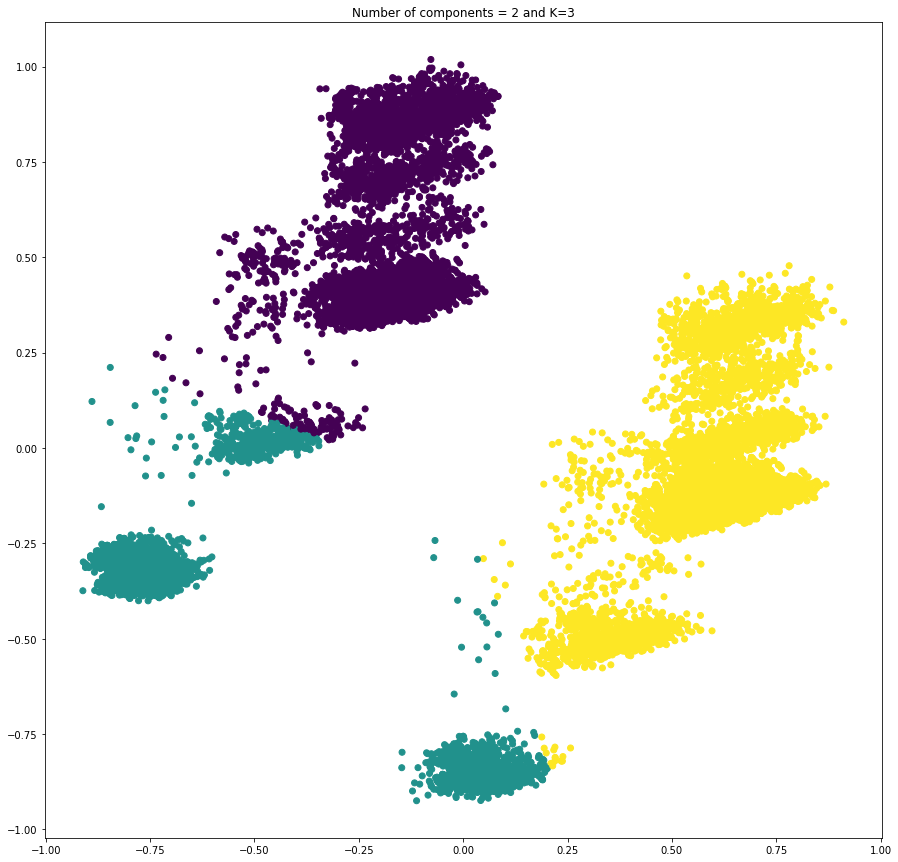

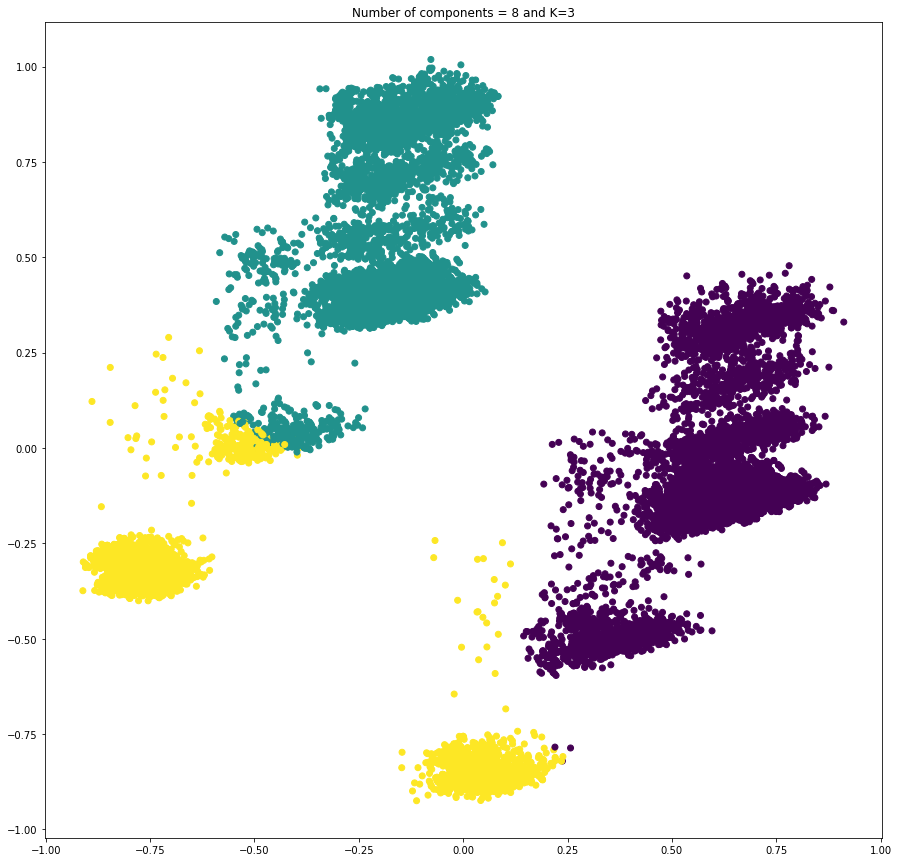

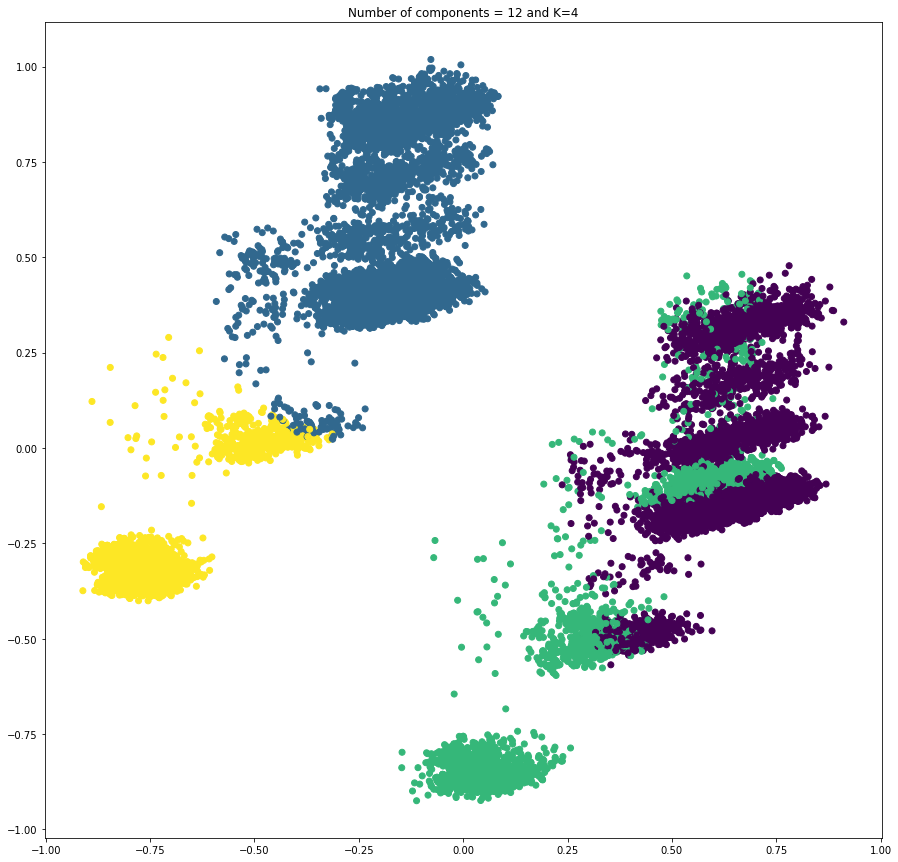

In [ ]:
for key, value in optmals_k.items():
  
  X_train_pca = pcas_sca[key].transform(X_train_sca)
  predict = models_sca[key][value].predict(X_train_pca)
  plt.figure(figsize=(15, 15))
  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=predict)
  plt.title("Predict data")
  plt.title(f"Number of components = {l}")
  plt.title(f"Number of components = {key} and K={value}")



Não normalizado

Para o caso não normalizado e número de componentes igual a 12, é notável que a dimensão das duas primeiras features possuem uma grande desproporção. Visualmente falando, os pontos não parecem ter uma separação clara. Esse fato ocorre, pois a normalização faz com que determinadas features se sobrepoem a outras e tendo resultados inesperados

Text(0.5, 1.0, 'Number of components = 12 and K=3')

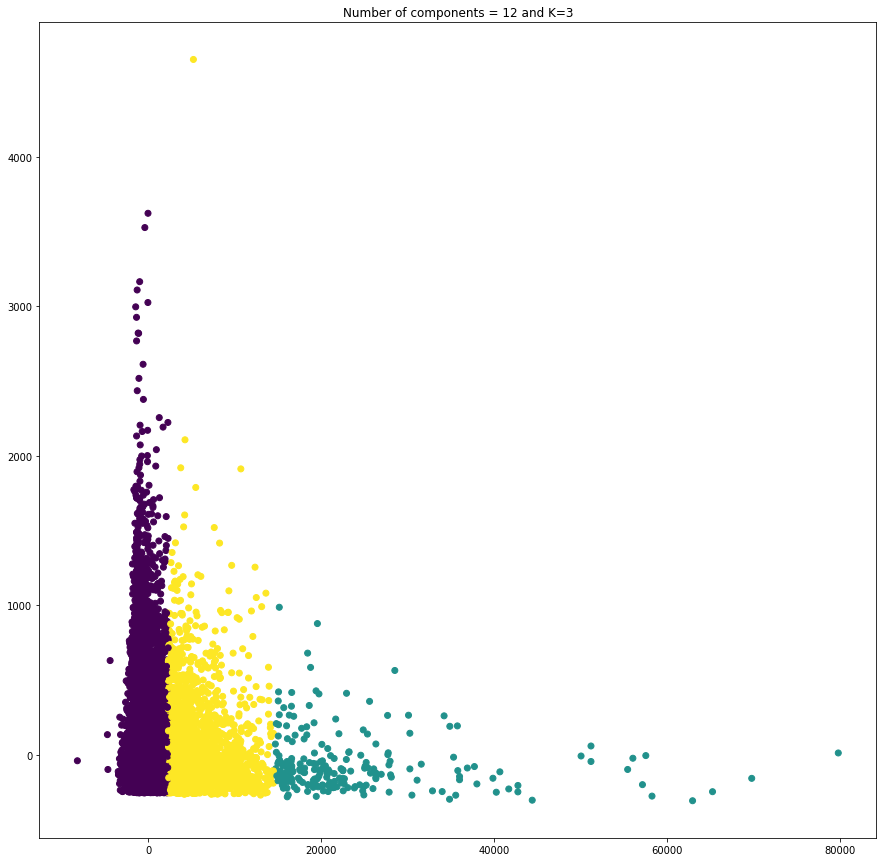

In [ ]:
X_train_pca = pca_enc.transform(X_train_enc)
predict = models_enc[optmal_k_enc].predict(X_train_pca)
plt.figure(figsize=(15, 15))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=predict)
plt.title("Predict data")

plt.title(f"Number of components = 12 and K={optmal_k_enc}")

####Silhouette

#####Normalizados

Todos modelos escolheram máximos sobre o coefiente médio de silhouette, mas apenas o primeiro coincidiu com o máximo global

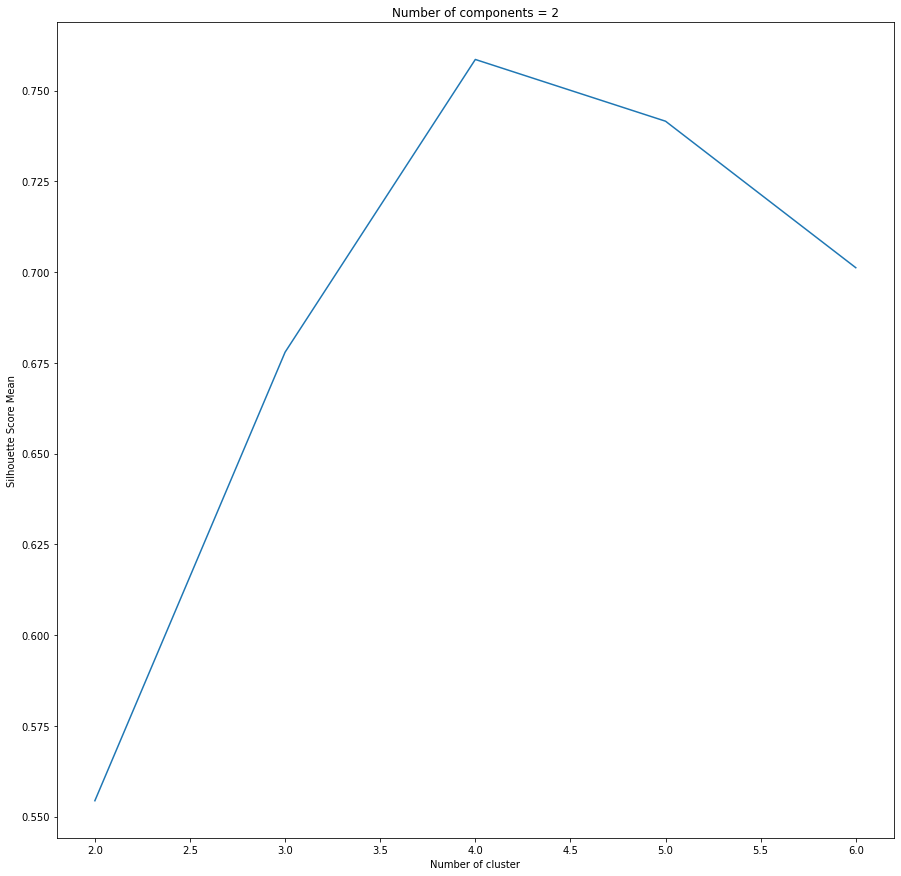

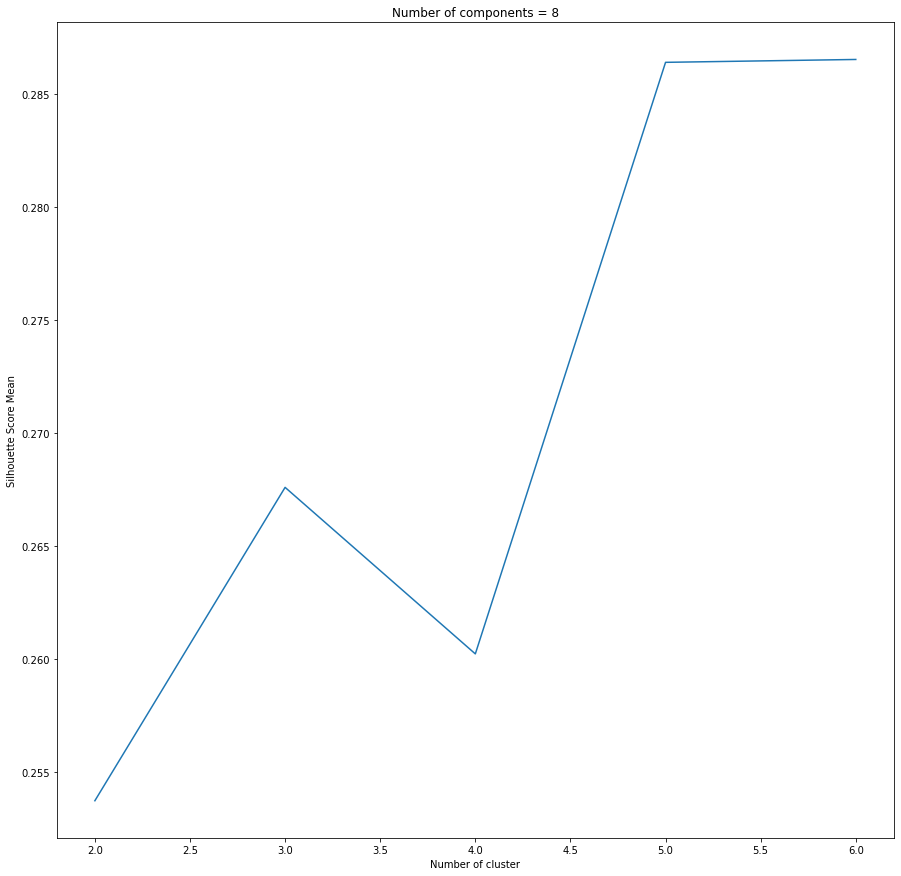

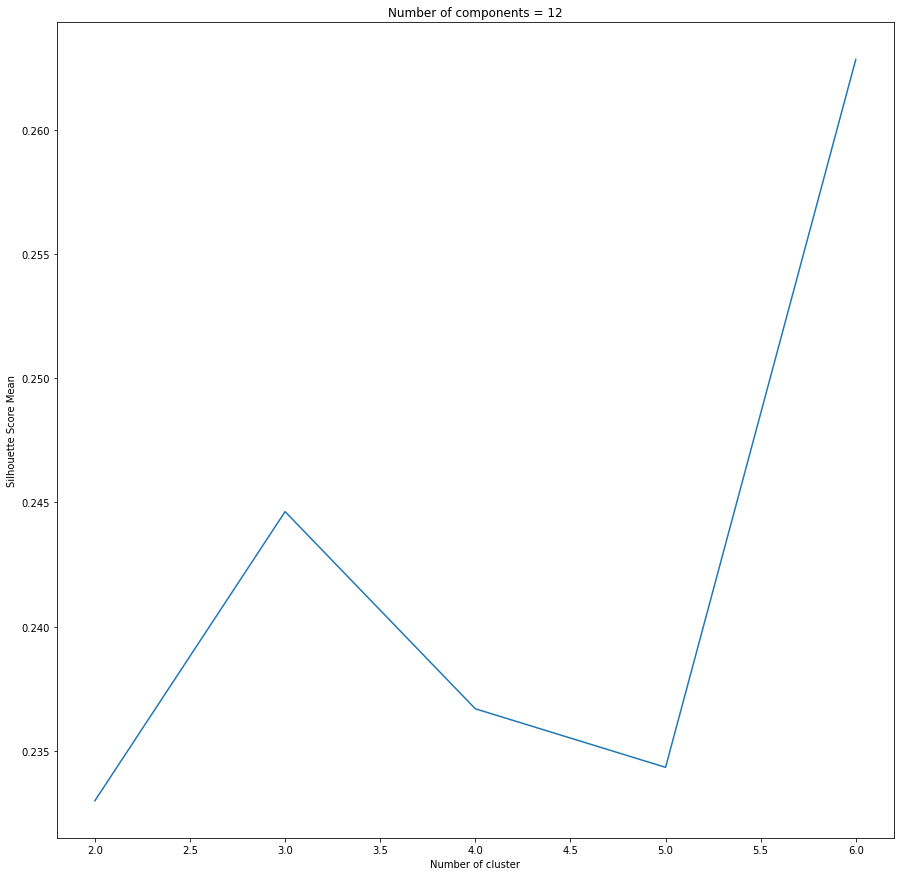

Tempo de execução = 4.473463650544485min


In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

import time
inicio = time.time()

for key, value in models_sca.items():
  silhouette_sca = {}
  for i, model in value.items():
      if(i==1): continue
      X = pcas_sca[key].transform(X_train_sca)
      silhouette_sca[i] = silhouette_score(X, model.predict(X))

  plt.figure(figsize=(15, 15))
  plt.plot(list(silhouette_sca.keys()), list(silhouette_sca.values()))
  plt.xlabel("Number of cluster")
  plt.ylabel("Silhouette Score Mean")
  plt.title(f"Number of components = {key}")
  plt.show()

print(f'Tempo de execução = {(time.time() - inicio)/60}min')


Abaixo vemos que os clusters 2 das duas primeiras figuras apresentaram uma faixa maior para o coeficiente de silhoutte de cada ponto. Por uma análise visual, esse fato realmente corrobora, pois a separação dele é melhor em relação aos outros clusters. Como a separação do terceiro modelo não é bem definida, vemos que as faixas de coeficientes possuem tamanhos distintos(uns acima da média e outra abaixo da média). Isso revela que os pontos não estão bem separados, fato que se reflete na mistura de pontos e clusters que ficam um do lado do outro. Além disso, o cluster 1  da primeira imagem não possui um bom agrupamento, fato que também é refletido nos coefientes de silhouette de cada ponto(vemos a discrepância em relação aos outros).

For n_clusters =3 e n_components = 2 The average silhouette_score is :0.6779642462528127


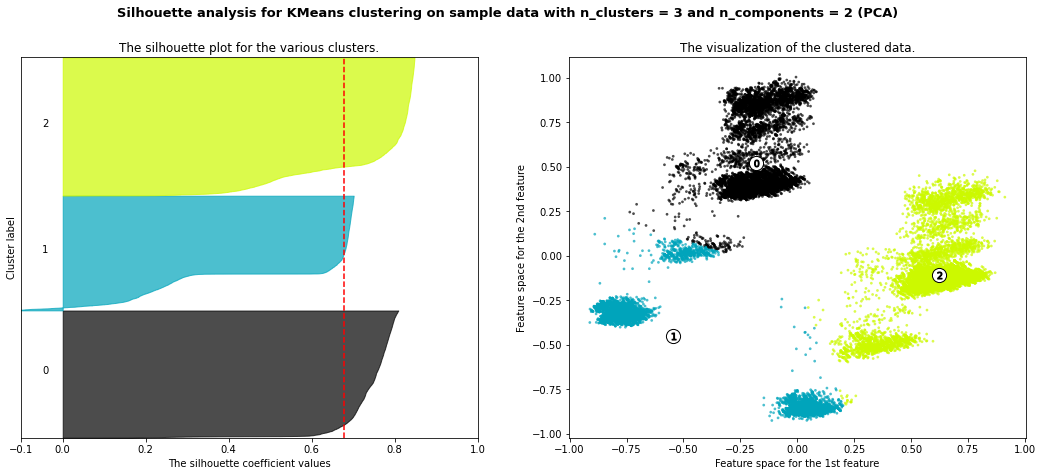

For n_clusters =3 e n_components = 8 The average silhouette_score is :0.2675926941908703


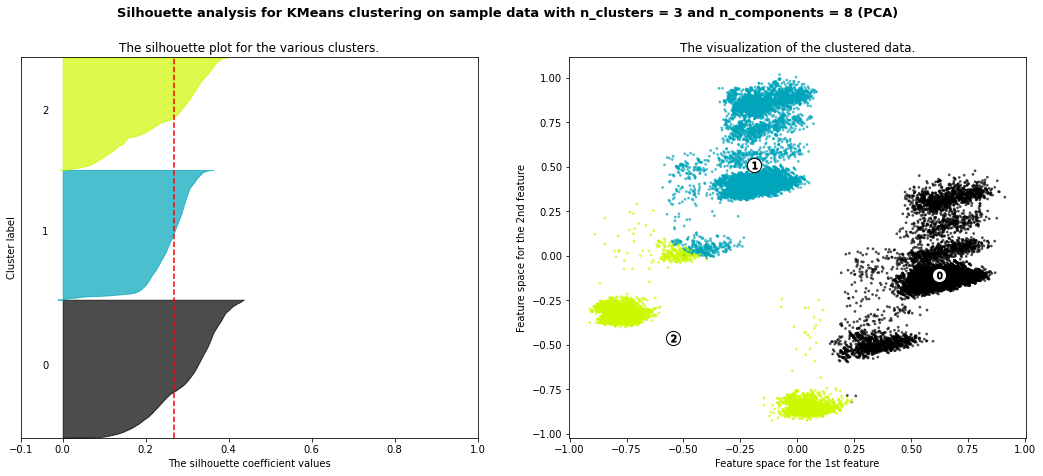

For n_clusters =4 e n_components = 12 The average silhouette_score is :0.23669743922931433


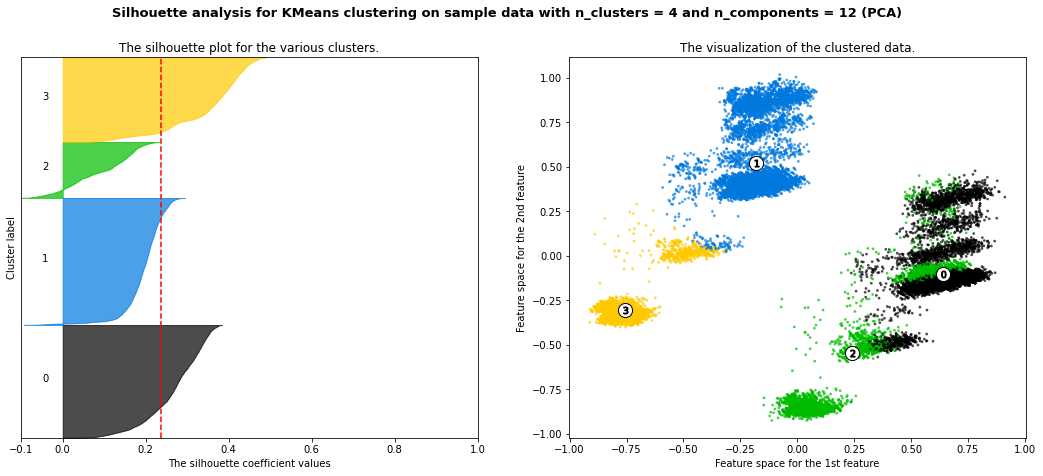

In [ ]:

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


for n_components, n_clusters in optmals_k.items():

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_train_sca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    model = models_sca[n_components][n_clusters] 
    clusterer = model
    X =pcas_sca[n_components].transform(X_train_sca) 
    cluster_labels = clusterer.predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'For n_clusters ={n_clusters} e n_components = {n_components} The average silhouette_score is :{silhouette_avg}')
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.centroids
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f'Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters} and n_components = {n_components} (PCA)', fontsize=13, fontweight='bold')

    plt.show()

#####Não normalizado
Notamos que o coeficiente de silhoutte abaixa com número de clusters. Esse fato se pelos dados não estarem bem separados. Como exemplo, vemos que a feature 1 se sobressai a feature 2, isso afeta diretamente o  cálculo de distância, fazendo com que o modelo considere praticamente apenas a feature 1, por exemplo.

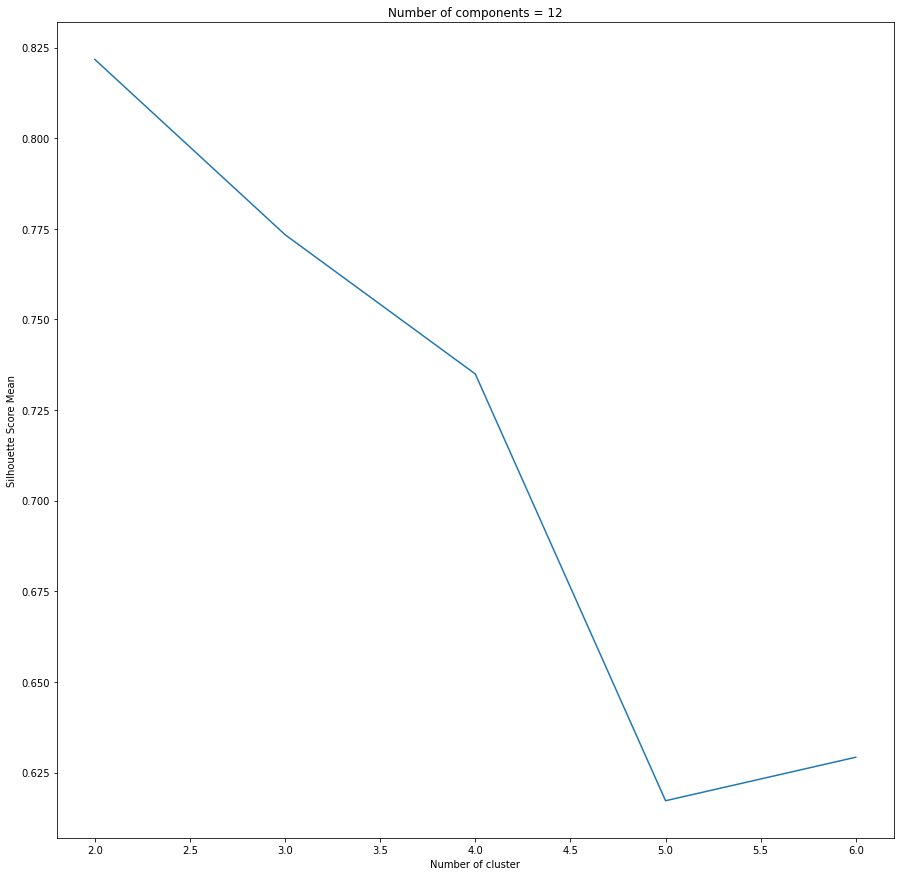

In [ ]:

silhouette_enc = {}
for i, model in models_enc.items():
    if(i==1): continue
    X = pca_enc.transform(X_train_enc)
    silhouette_enc[i] = silhouette_score(X, model.predict(X))

plt.figure(figsize=(15, 15))
plt.plot(list(silhouette_enc.keys()), list(silhouette_enc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score Mean")
plt.title(f"Number of components = 12")
plt.show()

Pela figura abaixo notamos as diferenças de densidade. Como os os clusters não estão bem separados, as faixas de coeficiente de silhouete para cada clusters estão discrepantes, fato que é esperado, já que os dados não estão bem separados.

For n_clusters =3  The average silhouette_score is :0.7733696288690287


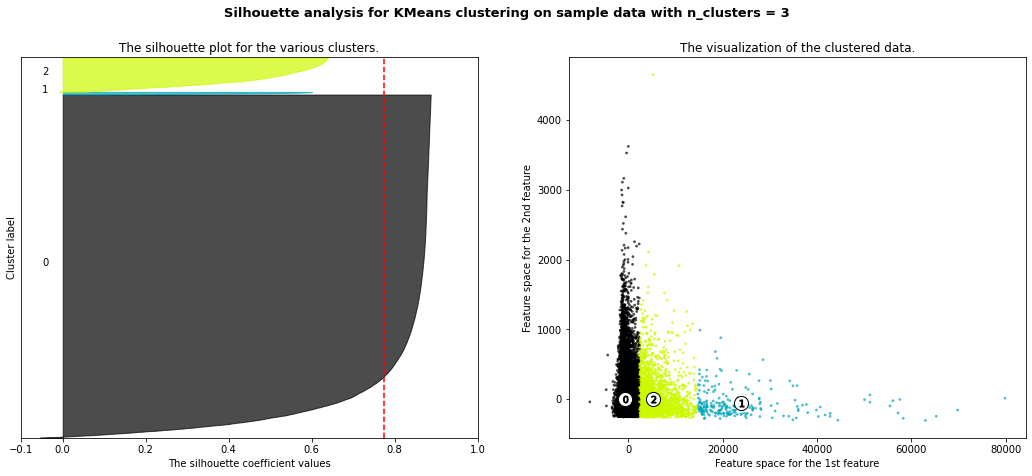

In [ ]:

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

n_clusters = optmal_k_enc

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X_train_sca) + (n_clusters + 1) * 10])

model = models_enc[optmal_k_enc] 
clusterer = model
X = pca_enc.transform(X_train_enc) 
cluster_labels = clusterer.predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(f'For n_clusters ={n_clusters}  The average silhouette_score is :{silhouette_avg}')
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear 
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.centroids
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(f'Silhouette analysis for KMeans clustering on sample data with n_clusters = {optmal_k_enc}', fontsize=13, fontweight='bold')

plt.show()

##Best Model
Pela visualização e avaliação dos modelos, chegamos a conclusão que nenhum dos modelos foi elencado como best model. Tudo depdende do ponto de vista

##Conclusão  Parte 2 
Portanto, mais uma vez vimos a importância da normalização dos dados para o PCA e o KMenas. Vemos que o PCA reduz a dimensionalidade do modelo mantendo uma determinada fidelidade(variância) aos dados, em determinados cenários isso ajuda a diminuir processamento e ganha-se tempo. Além disso, o coefiencde de silhouette nos ajudou a ver a qualidade dos clusters após acharmos o optmal K pelo Elbow Method. 